# Research Investigation on Interpretable Models and Regression Techniques

### Overview:

In this research, I delve into the application of interpretable models and regression techniques on two distinct datasets - the Acute Inflammations dataset and the Communities and Crime dataset. The primary focus is on decision trees as interpretable models and regression methods such as LASSO, Boosting, Ridge Regression, and PCR. The objective is to gain insights into the interpretability of decision trees and the predictive capabilities of regression models.

## 1. Decision Trees as Interpretable Models

Import packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn import tree
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.impute import SimpleImputer
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

### (a) Data Collection:

Acquire the Acute Inflammations dataset from the UCI Machine Learning Repository (https://archive.ics.uci.edu/ml/datasets/Acute+Inflammations).

In [21]:
file_path = '../hw5/diagnosis.data'
data = pd.read_csv(file_path, sep='\s+', encoding='UTF_16', header=None, decimal='.')
data['Patient_Temp'] = data[0].astype(str) + '.' + data[1].astype(str)
data.drop(columns=[0, 1], inplace=True)
data = data[['Patient_Temp'] + [col for col in data.columns if col != 'Patient_Temp']]
column_mapping = {
    2: 'Occurrence of nausea',
    3: 'Lumbar pain',
    4: 'Urine pushing',
    5: 'Micturition pains',
    6: 'Burning of urethra, itch, swelling of urethra outlet',
    7: 'Inflammation of urinary bladder',
    8: 'Nephritis of renal pelvis origin'
}
data.rename(columns=column_mapping, inplace=True)
print(data)

    Patient_Temp Occurrence of nausea Lumbar pain Urine pushing  \
0           35.5                   no         yes            no   
1           35.9                   no          no           yes   
2           35.9                   no         yes            no   
3           36.0                   no          no           yes   
4           36.0                   no         yes            no   
..           ...                  ...         ...           ...   
115         41.4                   no         yes           yes   
116         41.5                   no          no            no   
117         41.5                  yes         yes            no   
118         41.5                   no         yes           yes   
119         41.5                   no         yes           yes   

    Micturition pains Burning of urethra, itch, swelling of urethra outlet  \
0                  no                                                 no     
1                 yes                  

### (b) Decision Tree Construction:

Construct a decision tree using the entire dataset and visually represent it through a plot.

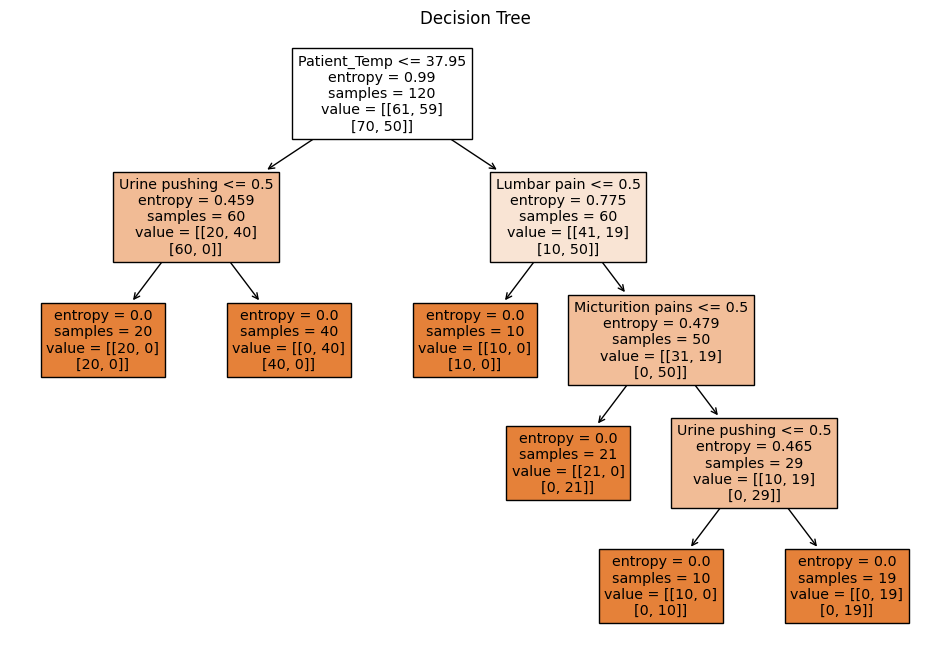

In [3]:
binary_columns = ['Occurrence of nausea', 'Lumbar pain',
                  'Urine pushing',
                  'Micturition pains',
                  'Burning of urethra, itch, swelling of urethra outlet',
                  'Inflammation of urinary bladder', 'Nephritis of renal pelvis origin']
for col in binary_columns:
    data[col] = data[col].map({'no': 0, 'yes': 1})
data.dropna(inplace=True)
X = data.drop(columns=['Inflammation of urinary bladder', 'Nephritis of renal pelvis origin'])
y = data[['Inflammation of urinary bladder', 'Nephritis of renal pelvis origin']]
dt = tree.DecisionTreeClassifier(criterion='entropy')
dt.fit(X, y)
plt.figure(figsize=(12, 8))
tree.plot_tree(dt, filled=True, feature_names=X.columns.tolist(), class_names=['No', 'Yes'])
plt.title("Decision Tree")
plt.show()

### (c) Rule Extraction:

Translate decision tree rules into a set of IF-THEN rules to enhance interpretability.

In [5]:
from sklearn.tree import _tree

def tree_to_code(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    
    code = ""
    
    def recurse(node, depth):
        nonlocal code
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            code += f"{indent}if {name} <= {threshold}:\n"
            recurse(tree_.children_left[node], depth + 1)
            code += f"{indent}else:  # if {name} > {threshold}\n"
            recurse(tree_.children_right[node], depth + 1)
        else:
            code += f"{indent}return {tree_.value[node]}\n"

    code += f"def decision_tree({', '.join(feature_names)}):\n"
    recurse(0, 1)
    
    return code

In [6]:
code = tree_to_code(dt, list(X.columns.tolist()))
print(code)

def decision_tree(Patient_Temp, Occurrence of nausea, Lumbar pain, Urine pushing, Micturition pains, Burning of urethra, itch, swelling of urethra outlet):
  if Patient_Temp <= 37.95000076293945:
    if Urine pushing <= 0.5:
      return [[20.  0.]
 [20.  0.]]
    else:  # if Urine pushing > 0.5
      return [[ 0. 40.]
 [40.  0.]]
  else:  # if Patient_Temp > 37.95000076293945
    if Lumbar pain <= 0.5:
      return [[10.  0.]
 [10.  0.]]
    else:  # if Lumbar pain > 0.5
      if Micturition pains <= 0.5:
        return [[21.  0.]
 [ 0. 21.]]
      else:  # if Micturition pains > 0.5
        if Urine pushing <= 0.5:
          return [[10.  0.]
 [ 0. 10.]]
        else:  # if Urine pushing > 0.5
          return [[ 0. 19.]
 [ 0. 19.]]



### (d) Cost-Complexity Pruning:

Employ cost-complexity pruning to identify a minimal decision tree and derive decision rules with increased interpretability.

In [7]:
feature_names = X.columns.tolist() 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
initial_tree = DecisionTreeClassifier(random_state=42)
initial_tree.fit(X_train, y_train)
path = initial_tree.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
best_alpha = ccp_alphas[np.argmax(impurities)]
pruned_tree = DecisionTreeClassifier(random_state=42, ccp_alpha=best_alpha)
pruned_tree.fit(X_train, y_train)
y_pred = pruned_tree.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of the pruned tree: {accuracy:.2f}")
tree_rules = export_text(pruned_tree, feature_names=feature_names)
print("Decision Rules:")
print(tree_rules)

Accuracy of the pruned tree: 0.25
Decision Rules:
|--- class: 1



## 2. The LASSO and Boosting for Regression

### (a) Data Collection:

Download the Communities and Crime dataset from the UCI Machine Learning Repository (https://archive.ics.uci.edu/ml/datasets/Communities+and+Crime).
Split the dataset into a training set (first 1495 rows) and a test set.

In [22]:
file_path_1 = '../hw5/communities.data'
communities = pd.read_csv(file_path_1, header=None)
print(communities)
train_data = communities.iloc[:1495, :]
test_data = communities.iloc[1495:, :]    

      0   1      2                    3    4     5     6     7     8     9    \
0       8   ?      ?         Lakewoodcity    1  0.19  0.33  0.02  0.90  0.12   
1      53   ?      ?          Tukwilacity    1  0.00  0.16  0.12  0.74  0.45   
2      24   ?      ?         Aberdeentown    1  0.00  0.42  0.49  0.56  0.17   
3      34   5  81440  Willingborotownship    1  0.04  0.77  1.00  0.08  0.12   
4      42  95   6096    Bethlehemtownship    1  0.01  0.55  0.02  0.95  0.09   
...   ...  ..    ...                  ...  ...   ...   ...   ...   ...   ...   
1989   12   ?      ?    TempleTerracecity   10  0.01  0.40  0.10  0.87  0.12   
1990    6   ?      ?          Seasidecity   10  0.05  0.96  0.46  0.28  0.83   
1991    9   9  80070        Waterburytown   10  0.16  0.37  0.25  0.69  0.04   
1992   25  17  72600          Walthamcity   10  0.08  0.51  0.06  0.87  0.22   
1993    6   ?      ?          Ontariocity   10  0.20  0.78  0.14  0.46  0.24   

      ...   118   119   120   121   122

### (b) Missing Values Handling:

Apply a data imputation technique to address missing values, while disregarding nonpredictive features mentioned in the data description.

In [9]:
non_predictive_attributes = communities.columns[0:6]
communities = communities.drop(columns=non_predictive_attributes)
communities.replace('?', np.nan, inplace=True)
numeric_columns = communities.select_dtypes(include='number').columns.tolist()
categorical_columns = communities.select_dtypes(exclude='number').columns.tolist()
numeric_imputer = SimpleImputer(strategy='mean')
communities[numeric_columns] = numeric_imputer.fit_transform(communities[numeric_columns])
categorical_imputer = SimpleImputer(strategy='most_frequent')
communities[categorical_columns] = categorical_imputer.fit_transform(communities[categorical_columns])
print(communities)

       6     7     8     9     10    11    12    13    14    15   ...   118  \
0     0.33  0.02  0.90  0.12  0.17  0.34  0.47  0.29  0.32  0.20  ...  0.12   
1     0.16  0.12  0.74  0.45  0.07  0.26  0.59  0.35  0.27  0.02  ...  0.02   
2     0.42  0.49  0.56  0.17  0.04  0.39  0.47  0.28  0.32  0.00  ...  0.01   
3     0.77  1.00  0.08  0.12  0.10  0.51  0.50  0.34  0.21  0.06  ...  0.02   
4     0.55  0.02  0.95  0.09  0.05  0.38  0.38  0.23  0.36  0.02  ...  0.04   
...    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
1989  0.40  0.10  0.87  0.12  0.16  0.43  0.51  0.35  0.30  0.03  ...  0.01   
1990  0.96  0.46  0.28  0.83  0.32  0.69  0.86  0.73  0.14  0.06  ...  0.02   
1991  0.37  0.25  0.69  0.04  0.25  0.35  0.50  0.31  0.54  0.17  ...  0.08   
1992  0.51  0.06  0.87  0.22  0.10  0.58  0.74  0.63  0.41  0.09  ...  0.03   
1993  0.78  0.14  0.46  0.24  0.77  0.50  0.62  0.40  0.17  0.21  ...  0.11   

       119   120   121   122   123  124   125   126

### (c)  Exploratory Analysis:

Generate a correlation matrix for dataset features.

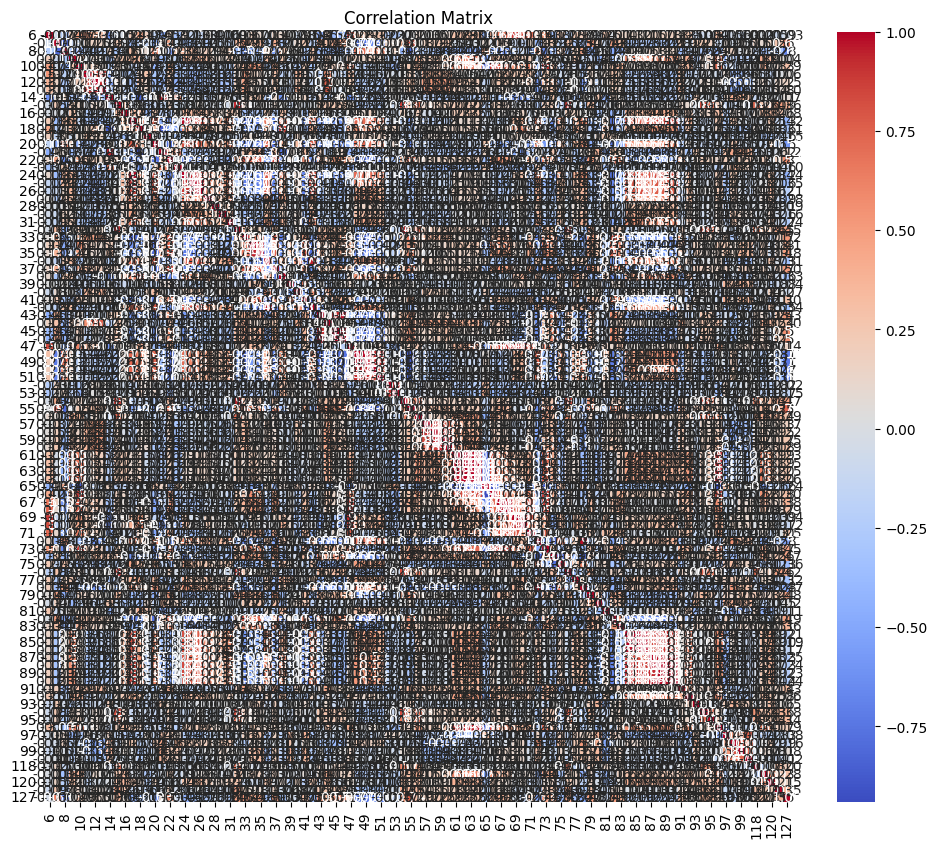

In [10]:
numeric_columns = communities.select_dtypes(include='number')
correlation_matrix = numeric_columns.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix")
plt.show()

### (d) Coefficient of Variation Calculation:

Calculate the Coefficient of Variation (CV) for each feature.

In [10]:
communities = communities.apply(pd.to_numeric, errors='coerce')
mean = communities.mean()
sd = communities.std()
cv = (sd / mean) * 100
print("Coefficient of Variation (CV) for each feature:")
print(cv)

Coefficient of Variation (CV) for each feature:
6       35.329830
7      141.092040
8       32.378156
9      135.916219
10     161.427779
          ...    
123     11.835392
124    324.744476
125    255.526600
126     54.028337
127     97.901480
Length: 122, dtype: float64


### (e) Feature Analysis:

Select features with the highest CV and create scatter plots and box plots to draw preliminary conclusions about their significance.


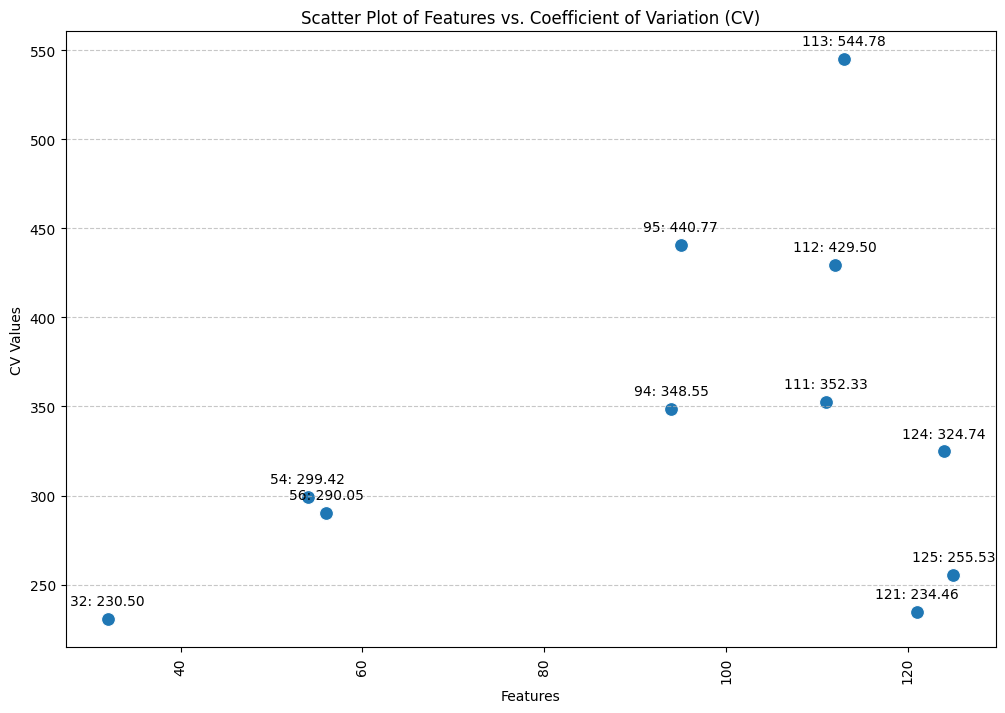

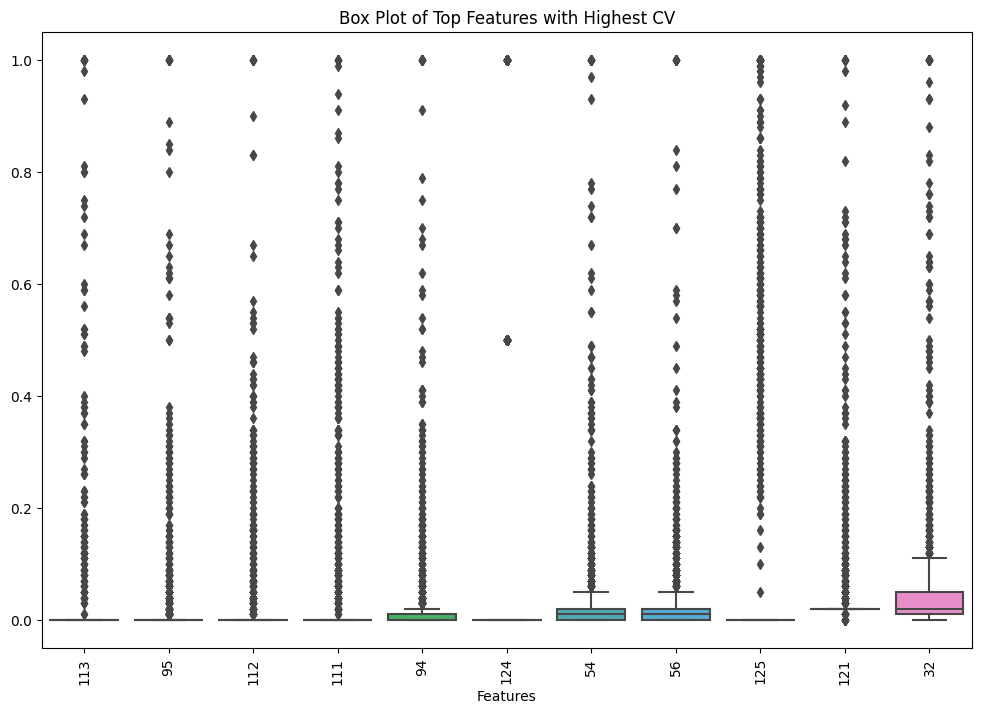

In [11]:
num_features = int(np.sqrt(128))
heigest_features = cv.abs().sort_values(ascending=False).head(num_features)
plt.figure(figsize=(12, 8))
sns.scatterplot(x=heigest_features.index, y=heigest_features.values, s=100)
plt.title("Scatter Plot of Features vs. Coefficient of Variation (CV)")
plt.xlabel("Features")
plt.ylabel("CV Values")
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
for i, feature in enumerate(heigest_features.index):
    plt.annotate(f"{feature}: {heigest_features.values[i]:.2f}", (feature, heigest_features.values[i]), textcoords="offset points", xytext=(0, 10), ha='center')
plt.show()
plt.figure(figsize=(12, 8))
sns.boxplot(data=communities[heigest_features.index])
plt.title("Box Plot of Top Features with Highest CV")
plt.xlabel("Features")
plt.xticks(rotation=90)
plt.show()

### (f) Linear Model Fitting:

Fit a linear model to the training set using least squares and report the test error.

In [12]:
train_data = communities.iloc[:1495, :]
test_data = communities.iloc[1495:, :]
X_train = train_data.iloc[:, 0:121]  
y_train = train_data.iloc[:, 121]    
X_test = test_data.iloc[:, 0:121]  
y_test = test_data.iloc[:, 121]  

In [13]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (MSE): {:.2f}".format(mse))

Mean Squared Error (MSE): 6089722088948436992.00


### (g) Ridge Regression:

Implement ridge regression on the training set with λ chosen via cross-validation, reporting the resulting test error.

In [14]:
ridge_model = RidgeCV(alphas=[0.01, 0.1, 1, 10]) 
ridge_model.fit(X_train, y_train)
y_pred_ridge = ridge_model.predict(X_test)
ridge_test_error = mean_squared_error(y_test, y_pred_ridge)
print(f"Test Error (Ridge Regression): {ridge_test_error:.2f}")

Test Error (Ridge Regression): 0.02


### (h) LASSO model

Fit a LASSO model on the training set with λ chosen through cross-validation. Report test error and list the selected variables. Repeat the process with standardized features and compare results.

In [15]:
lasso_model = LassoCV(alphas=[0.01, 0.1, 1, 10]) 
lasso_model.fit(X_train, y_train)
y_pred_lasso = lasso_model.predict(X_test)
lasso_test_error = mean_squared_error(y_test, y_pred_lasso)
print(f"Test Error (LASSO Regression): {lasso_test_error:.2f}")

Test Error (LASSO Regression): 0.02


### (i) PCR model

Fit a Principal Component Regression (PCR) model on the training set with the number of principal components (M) chosen via cross-validation. Report the test error.

In [17]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
import numpy as np
M_values = range(1, 122) 
cv_scores = []
for M in M_values:
    pcr_model = Pipeline([
        ('pca', PCA(n_components=M)),
        ('linear_regression', LinearRegression())
    ])

    cv_score = -np.mean(cross_val_score(pcr_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error'))
    cv_scores.append(cv_score)
optimal_M = M_values[np.argmin(cv_scores)]
optimal_pcr_model = Pipeline([
    ('pca', PCA(n_components=optimal_M)),
    ('linear_regression', LinearRegression())
])

optimal_pcr_model.fit(X_train, y_train)
y_pred_pcr = optimal_pcr_model.predict(X_test)
pcr_test_error = mean_squared_error(y_test, y_pred_pcr)
print(f"Test Error (PCR with {optimal_M} components): {pcr_test_error:.2f}")

Test Error (PCR with 96 components): 0.02


### (j) Fit a boosting tree

In [20]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
alphas = [0.01, 0.1, 1, 10]
xgb_regressor = xgb.XGBRegressor(objective='reg:squarederror')
param_grid = {'alpha': alphas}
grid_search = GridSearchCV(estimator=xgb_regressor, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_train, y_train)
best_alpha = grid_search.best_params_['alpha']
final_xgb_model = xgb.XGBRegressor(objective='reg:squarederror', alpha=best_alpha)
final_xgb_model.fit(X_train, y_train)
y_pred = final_xgb_model.predict(X_test)
test_error = mean_squared_error(y_test, y_pred)
print("Best alpha (regularization term):", best_alpha)
print("Test error for the best model:", test_error)

Best alpha (regularization term): 1
Test error for the best model: 0.018074362373473735


This research aims to provide a comprehensive understanding of interpretable models and regression techniques, exploring their application on diverse datasets and drawing insights into model interpretability and predictive performance.